#### COEXIST paper section 3: For each U.S. river basin region
 over view map plot of 14-day P99 event count 
 - a) plot probability distributions of 14-day P99 event overlap fraction
 - b) scatter plots of 14-day P99 event count vs. overlap fraction

Ming Ge Oct 2023

In [1]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import pandas as pd
import datetime
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import shapefile   
import geopandas as gpd
import geoplot as gplt
import contextily as cx
from shapely.geometry import Point, Polygon
from rasterio import features
from affine import Affine

from fitter import Fitter, get_common_distributions, get_distributions
import matplotlib.pyplot as plt

In [2]:
# Reference:
# https://stackoverflow.com/questions/51398563/python-mask-netcdf-data-using-shapefile
def transform_from_latlon(lat, lon):
    """ input 1D array of lat / lon and output an Affine transformation
    """
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude, longitude,
              fill=np.nan, **kwargs):
    """
    Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.

    usage:
    -----
    1. read shapefile to geopandas.GeoDataFrame
          `states = gpd.read_file(shp_dir+shp_file)`
    2. encode the different shapefiles that capture those lat-lons as different
        numbers i.e. 0.0, 1.0 ... and otherwise np.nan
          `shapes = (zip(states.geometry, range(len(states))))`
    3. Assign this to a new coord in your original xarray.DataArray
          `ds['states'] = rasterize(shapes, ds.coords, longitude='X', latitude='Y')`

    arguments:
    ---------
    : **kwargs (dict): passed to `rasterio.rasterize` function

    attrs:
    -----
    :transform (affine.Affine): how to translate from latlon to ...?
    :raster (numpy.ndarray): use rasterio.features.rasterize fill the values
      outside the .shp file with np.nan
    :spatial_coords (dict): dictionary of {"X":xr.DataArray, "Y":xr.DataArray()}
      with "X", "Y" as keys, and xr.DataArray as values

    returns:
    -------
    :(xr.DataArray): DataArray with `values` of nan for points outside shapefile
      and coords `Y` = latitude, 'X' = longitude.


    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def plot_2d(lat, lon, data_2d, color_map, title_s):
    fig = plt.figure(figsize=(11,8.5))

    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())
    
    # Make a filled contour plot
    filled_c = ax.contourf(lon, lat, data_2d, cmap = color_map, transform = ccrs.PlateCarree())

    # Add coastlines
    ax.coastlines()
    ax.add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
    ax.set_title(title_s)

    # Add a colorbar for the filled contour.
    # and pad argument to set colorbar away from x-axis
    fig.colorbar(filled_c , orientation="horizontal", pad = 0.05);

#### some setups

In [3]:
# ERA5 U.S. mask I'm going to use to mask large domain for speed up
flnm_mask = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/masks/NLDAS_ERA5_US_mask_regrid.nc'
with  xr.open_dataset(flnm_mask) as ds_mask:
    print(flnm_mask)
    US_mask = ds_mask.US_mask
    
lat_s = min(ds_mask.lat.values)
lat_e = max(ds_mask.lat.values)

lon_s = min(ds_mask.lon.values)
lon_e = max(ds_mask.lon.values)
print(US_mask.shape, lat_s, lat_e, lon_s, lon_e)

/glade/campaign/mmm/c3we/COEXIST/ERA5_events/masks/NLDAS_ERA5_US_mask_regrid.nc
(110, 230) 25.5 52.75 235.25 292.5


In [4]:
# mask event file
dir_o = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/'
flnm_obj_mask = dir_o + 'ERA5_accumulated_daily_pr_p99_event_numbers_1979-2020_US_mask_regrid.nc'
print(flnm_obj_mask)

if os.path.isfile(flnm_obj_mask):
    with xr.open_dataset(flnm_obj_mask) as ds:
        event_crop = ds.event.values
        date_nc_1d = ds.date.values
else:
    flnm_obj_large = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/ERA5_accumulated_daily_pr_p99_event_numbers_1979-2020_US_large.nc'
    print(flnm_obj_large)
    #cropped_ds = ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    with xr.open_dataset(flnm_obj_large) as ds:
        event_crop = ds.event.sel(lat=slice(lat_e, lat_s), lon=slice(lon_s, lon_e))
        date_nc_1d = ds.date.values
        # mask
        event_crop = event_crop.where(US_mask>0)
        
        # # from np array to xarray
        event_crop_xr = xr.DataArray(event_crop, 
                        coords={'date': ds.date, 'lat': ds_mask.lat, 'lon': ds_mask.lon}, 
                        dims=["date", "lat", "lon"])
        ds = event_crop_xr.to_dataset(name = 'event')
        ds.attrs['script'] = 'Ming Ge: obj_overlap.ipynb'
        ds.to_netcdf(flnm_o)

/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/ERA5_accumulated_daily_pr_p99_event_numbers_1979-2020_US_mask_regrid.nc


#### overview of P99 OBJ overlap (1979-2020)  

CPU times: user 11.2 s, sys: 0 ns, total: 11.2 s
Wall time: 11.7 s


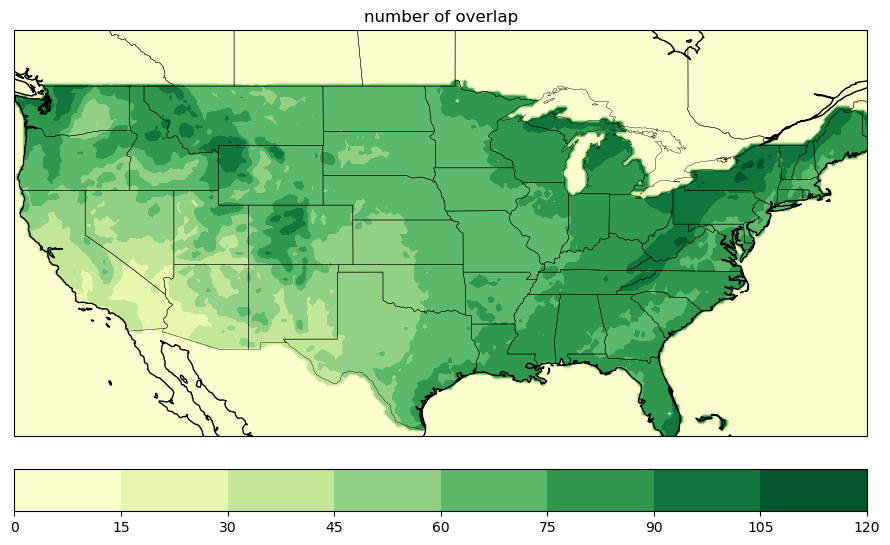

In [7]:
%%time
event_ct_2d = np.zeros((event_crop.shape[1], event_crop.shape[2]))
for ii in range(event_crop.shape[1]):
    for jj in range(event_crop.shape[2]):
        event_ct_2d[ii,jj] = len(np.unique(event_crop[:,ii,jj])) - 1
plot_2d(ds_mask.lat, ds_mask.lon, event_ct_2d, 'YlGn', 'number of overlap') 

 - 14-day event count of each basin from OBJ txt file

In [5]:
StartDay = datetime.datetime(1979, 1, 1,  0)
StopDay  = datetime.datetime(2020, 12, 31, 23)

TimeDD = pd.date_range(StartDay, end=StopDay, freq='d')
n_day = len(TimeDD)

window_size = 14

In [6]:
%%time
# read Obj file and group it according to HUC
dir_obj_txt = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/'
flnm_obj_txt = dir_obj_txt + 'ERA5_accumulated_daily_pr_p99_2d_events_1979-2020_US.txt'
print(flnm_obj_txt)

df = pd.read_csv(flnm_obj_txt, sep=" ")  
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
 
# Split Data into 'HUC2' Groups by .groupby() function. 
# This returns a GroupBy object which is a dictionary
# Then use different methods on this object 
huc2_g = df.groupby(['HUC2']) 

# number of unique groups
# the same as df.HUC2.nunique() 
n_huc2 = huc2_g.ngroups 
print('there are: ', n_huc2, ' groups')
 
n_ActDD = n_day - window_size + 1
n_event_2d = np.zeros((n_huc2, n_day), dtype=int)
ns = 0
for name_of_group, contents_of_group in huc2_g: 
    event_date = contents_of_group[['event_id', 'date']]
    print(name_of_group)
    ii = 0
    while ii < n_ActDD:
        window = TimeDD[ii : ii + window_size]
        # select rows between two values: 14-day count here
        event_select = event_date[event_date['date'].between(window[0], window[-1])]
        # count events by unique event_id
        n_event_2d[ns,ii] = len(np.unique(event_select['event_id'].to_numpy()))
        ii = ii + 1
    ns = ns + 1

/glade/campaign/mmm/c3we/COEXIST/ERA5_events/ERA5_events/ERA5_accumulated_daily_pr_p99_2d_events_1979-2020_US.txt
there are:  18  groups
('Arkansas',)
('CoastalBasinsNP',)
('Colorado',)
('Columbia',)
('GreatBasin',)
('GreatLakes',)
('LowerMississippi',)
('LowerMissouri',)
('NorthAtlantic',)
('Ohio',)
('RedAndOuachita',)
('RedRiver',)
('RioGrande',)
('SacramentoAndKlamath',)
('Southeast',)
('Texas',)
('UpperMississippi',)
('UpperMissouri',)
CPU times: user 2min 11s, sys: 141 ms, total: 2min 11s
Wall time: 2min 17s


In [7]:
%%time
# reorder obj txt file 'huc2' according to US river basins shapefile
name_obj = (list(huc2_g.groups.keys()))
name_obj = [sub.lower() for sub in name_obj]

flnm_shp = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/US_river_basins/US_river_basins.shp'
shp_gpd = gpd.read_file(flnm_shp)

# reorder count according to shapefile order
# series to list
name_shp = shp_gpd.names.tolist() 

# Replace substring in list of strings
name_shp = [sub.replace(' ', '').lower() for sub in name_shp]

n_event_2d_new = np.zeros((n_huc2, n_day), dtype=int)

#reorder obj huc according to shapefile 
for ns in range(n_huc2):
    # get the index of name_shp[ns]
    index = name_obj.index(name_shp[ns])
    n_event_2d_new[ns] = n_event_2d[index]
    #print(n_event_2d_new[ns], name_shp[ns], name_obj[index], n_event_2d[index])

CPU times: user 293 ms, sys: 29.8 ms, total: 323 ms
Wall time: 461 ms


 - calculate 14-day event count at each ERA5 grid 

In [8]:
# calculate 14-day running events count
dir_o = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/'
flnm_obj_mask_14day = dir_o + 'ERA5_14day_accumulated_daily_pr_p99_event_numbers_1979-2020_US_mask_regrid.nc'
print(flnm_obj_mask_14day)

if os.path.isfile(flnm_obj_mask_14day):
    with  xr.open_dataset(flnm_obj_mask_14day) as ds_obj_mask_14day:
        # because of shapefile longitude -180 to 180
        ds_obj_mask_14day.coords['lon'] = ds_obj_mask_14day.coords['lon'] - 360
        event_14day_3d = ds_obj_mask_14day.event_14day
        date_nc_1d = ds_obj_mask_14day.date
                             
else:
    event_14day_3d = np.zeros((n_day, event_crop.shape[1], event_crop.shape[2]))
    nd = 0
    while nd < n_ActDD:
        for ii in range(event_crop.shape[1]):
            for jj in range(event_crop.shape[2]):
                event_14day_3d[nd, ii,jj] = len(np.unique(event_crop[nd:nd+window_size,ii,jj])) - 1
                
        nd = nd + 1  
        
    # from np array to xarray
    event_14day_xr = xr.DataArray(event_14day_3d, 
                        coords={'date': ds.date, 'lat': ds_mask.lat, 'lon': ds_mask.lon}, 
                        dims=["date", "lat", "lon"])
    ds = event_14day_xr.to_dataset(name = 'event_14day')
    ds.attrs['script'] = 'Ming Ge: obj_overlap.ipynb'
    ds.to_netcdf(flnm_obj_mask_14day)


/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/ERA5_14day_accumulated_daily_pr_p99_event_numbers_1979-2020_US_mask_regrid.nc


In [9]:
# 14-day P99 event overlap and over all coverage
over_lap = xr.where(event_14day_3d < 2., 0, 1)
over_lap_xr = xr.DataArray(over_lap, 
                        coords={'date': ds.date, 'lat': ds_mask.lat, 'lon': ds_mask.lon-360}, 
                        dims=["date", "lat", "lon"])
ds_overlap = over_lap_xr.to_dataset(name = 'over_lap')

over_all = xr.where(event_14day_3d == 0., 0, 1)
over_all_xr = xr.DataArray(over_all, 
                        coords={'date': ds.date, 'lat': ds_mask.lat, 'lon': ds_mask.lon-360}, 
                        dims=["date", "lat", "lon"])
ds_overall = over_all_xr.to_dataset(name = 'over_all')
#ds_overall.over_all[0].plot();

 - calculate overlap fraction according to each basin <br>
 note: if there is no event, put -99 as fillValue

In [10]:
%%time
# read in shapefile
flnm_shp = '/glade/campaign/mmm/c3we/COEXIST/ERA5_events/US_river_basins/US_river_basins.shp'
shp_gpd = gpd.read_file(flnm_shp)

#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
shp_gpd = shp_gpd.to_crs('EPSG:4326')
n_shp = len(shp_gpd.geometry)
 
#  create a list of tuples (shapely.geometry, id)
#  this allows for many different polygons within a .shp file (e.g. basins of US)
shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
    
# read Grided ERA5 dataset and add shapes DataArray
# create a new coord in the xr_da which will be set to the id in `shapes`
ds_overlap['US_river_basins'] = rasterize(shapes, ds_overlap.coords, longitude='lon', latitude='lat')
ds_overall['US_river_basins'] = rasterize(shapes, ds_overall.coords, longitude='lon', latitude='lat')
 
fraction_2d = np.zeros((n_shp, n_day), dtype=int)
for ns in range(n_shp):
    ds_overlap_county = ds_overlap.where(ds_overlap.US_river_basins==ns, other=np.nan)
    ds_overall_county = ds_overall.where(ds_overall.US_river_basins==ns, other=np.nan)
    # ds_overall_county.over_all[0].plot()
    print(ns)
    fraction_2d[ns] = xr.where(ds_overall_county.over_all.sum(axis=(1,2))==0, -99, ds_overlap_county.over_lap.sum(axis=(1,2))/ \
                      ds_overall_county.over_all.sum(axis=(1,2))*100)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
CPU times: user 1min 58s, sys: 3min 31s, total: 5min 30s
Wall time: 5min 51s


 - a) probability distributions of 14-day P99 event overlap fraction

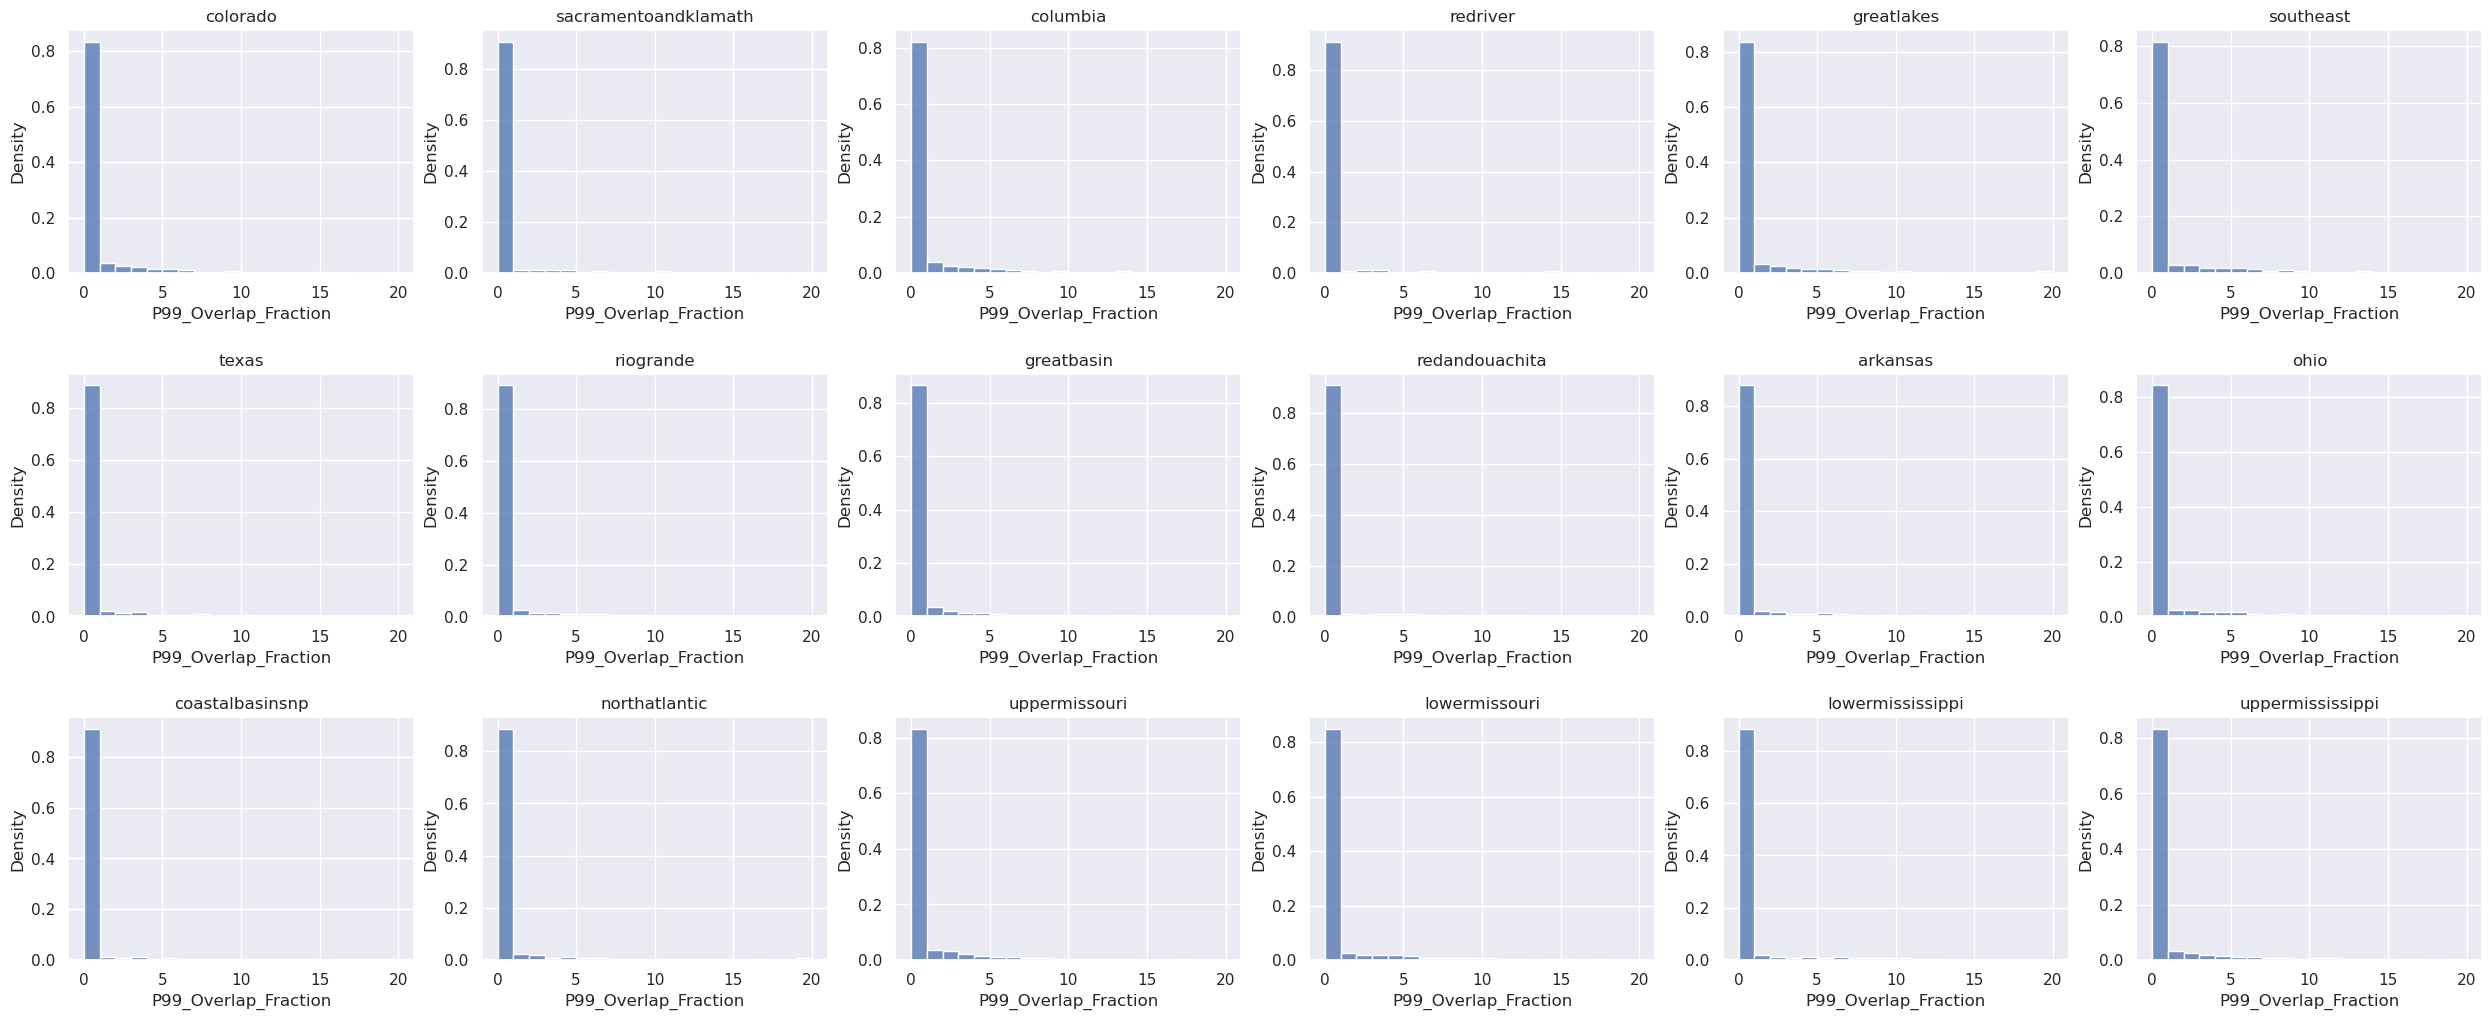

In [13]:
# plotting a histogram
#set seaborn plotting aesthetics as default
sns.set()

n_col = 6
n_row = 3

bins = np.arange(0,21,1)

#define plotting region (3 rows, 6 columns)
fig, axes = plt.subplots(n_row, n_col, figsize=(25, 10))
fig.tight_layout(h_pad=4)
for ns in range(n_shp):
    nrow = int(ns/n_col)
    ncol = ns - nrow*n_col 
     
    # Create the pandas DataFrame with column name is provided explicitly 
    data = {'P99_Overlap_Fraction': fraction_2d[ns, :-14], 'date' : TimeDD[:-14]}
    df = pd.DataFrame(data) 
    
    # remove FillValue
    df = df[df.P99_Overlap_Fraction != -99]
    sns.histplot(ax=axes[nrow, ncol], data=df["P99_Overlap_Fraction"], bins = bins, stat="density").set(title=name_shp[ns]) #, binwidth=1).set(title=name_shp[ns])
 

- b) scatter plots of 14-day P99 event count vs. overlap fraction

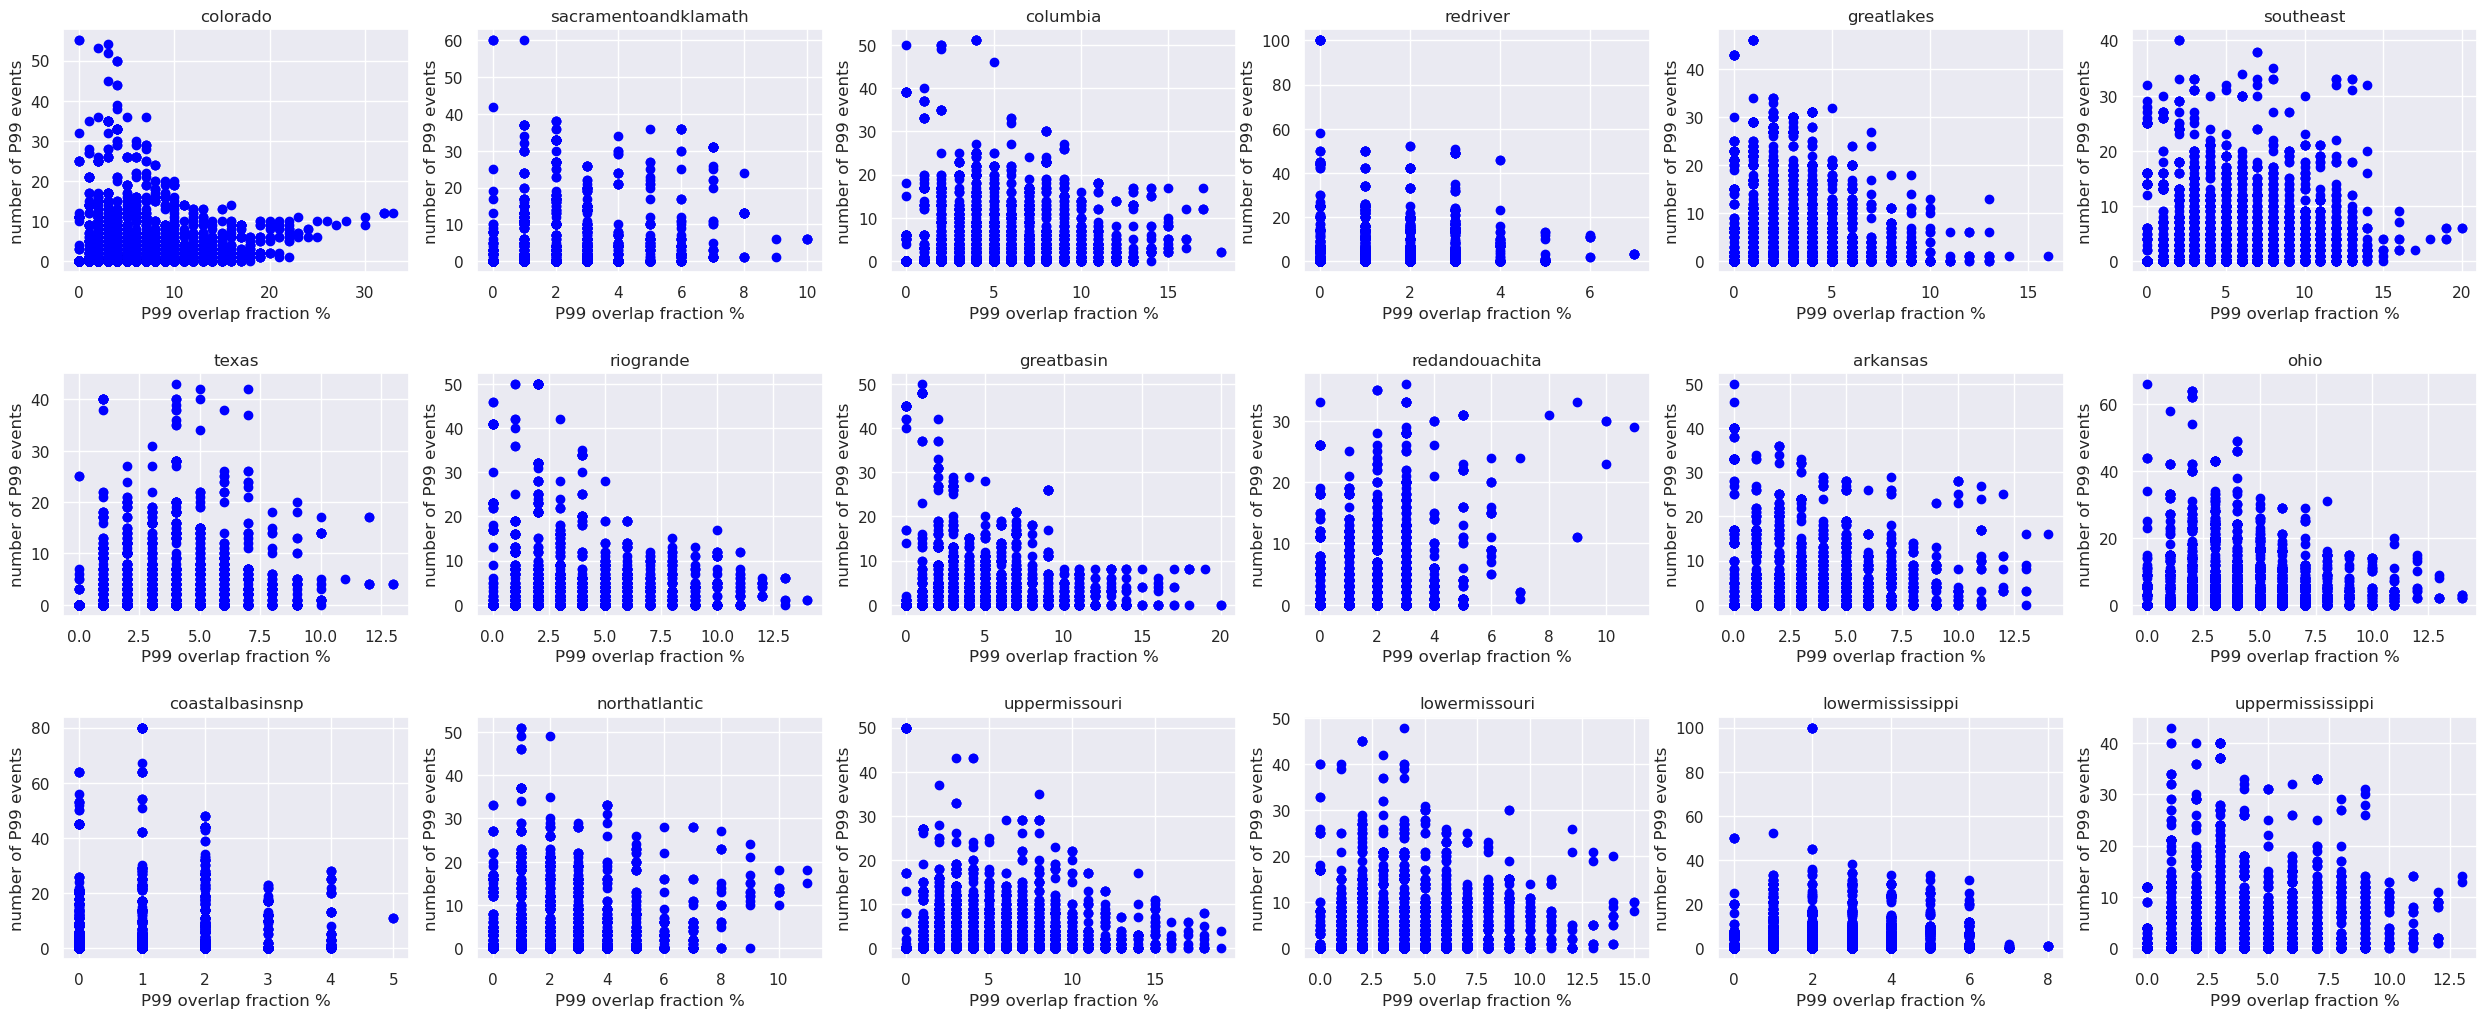

In [14]:
event_14day_3d
#define plotting region (3 rows, 6 columns)
fig, axes = plt.subplots(n_row, n_col, figsize=(25, 10))
fig.tight_layout(h_pad=4)
for ns in range(n_shp):
    nrow = int(ns/n_col)
    ncol = ns - nrow*n_col 
     
    # Create the pandas DataFrame with column name is provided explicitly 
    data = {'P99_Overlap_Fraction': fraction_2d[ns, :-14], 'NumberOfEvent' : n_event_2d_new[ns,:-14]}
    df = pd.DataFrame(data) 
    
    # remove FillValue
    df = df[df.P99_Overlap_Fraction != -99]
    
    axes[nrow,ncol].scatter( df.NumberOfEvent, df.P99_Overlap_Fraction, c ="blue")
    axes[nrow,ncol].set_xlabel("P99 overlap fraction %")
    axes[nrow,ncol].set_ylabel("number of P99 events")
    axes[nrow,ncol].set_title(name_shp[ns])